# For Reference

In [11]:
with open('data/all_apps_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [10]:
df[df['item_name'] == 'Leather Hoodie (White)'].tail()

In [ ]:
plt.plot(df_hoodie.date, df_hoodie.median_sell_price)

In [ ]:
autocorrelation_plot(df_hoodie.median_sell_price)

In [ ]:
model = ARIMA(df_hoodie.median_sell_price,order=(10, 1, 0))
model = model.fit(disp=0)
model.summary()

In [ ]:
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
from sklearn.metrics import mean_squared_error
X = df_hoodie.median_sell_price.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(10,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
model.resid[model.resid<-1.5]

In [ ]:
df_gun.iloc[178,:]

In [ ]:
df_gun.iloc[709,:]

In [ ]:
datetime.datetime.fromtimestamp(1.44973e+09)

In [ ]:
datetime.datetime.fromtimestamp(1.4956e+09)

In [ ]:
model.resid.sort_values()[:3]

In [ ]:
model.resid.sort_values()[-3:]

In [ ]:
df_gun.iloc[1047]

In [ ]:
from saxpy.alphabet import cuts_for_asize
cuts_for_asize(3) 

In [ ]:
import numpy as np
from saxpy.znorm import znorm
from saxpy.sax import ts_to_string
ts_to_string(znorm(np.array([-2, 0, 2, 0, -1])), cuts_for_asize(3))

In [ ]:
import numpy as np
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string
import saxpy

dat = np.array([-2, 0, 2, 0, -1])
dat_znorm = znorm(dat)
dat_paa_3 = paa(dat_znorm, 3)

ts_to_string(dat_paa_3, cuts_for_asize(3))

In [ ]:
import numpy as np
from saxpy.hotsax import find_discords_hotsax
from numpy import genfromtxt
dd = df_hoodie.median_sell_price.values
dd = df_gun.median_sell_price.values
discords = find_discords_hotsax(dd)
discords

# ARIMA Work

In [8]:
import numpy as np
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
import pickle
import matplotlib.pyplot as plt
from pymongo import MongoClient
import time
import datetime
import os
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
import scipy.stats as scs
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings # We get some interger -> float typecast warning from sklean
warnings.filterwarnings('ignore')
def fromts(dt): return datetime.datetime.fromtimestamp(dt)
def tots(dt): return time.mktime(datetime.datetime.strptime(dt, "%b %d %Y").timetuple())
from plot_arima import fit_moving_average_trend, plot_raw, plot_moving_average, plot_resid

In [9]:
plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
with open('data/all_apps_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [4]:
def strip_early_days(df, n_days):
    df = df.reset_index().drop(columns='index')
    df['early_days'] = df.groupby(by=['item_name'], as_index=False).transform('min').date
    df.early_days = df.early_days + n_days*24*60*60 - 1 #num_days * 24 h/d * 60 m/h * 60 s/m
    df = df[df.date > df.early_days]
    return df.reset_index().drop(columns=['index','early_days'])

In [6]:
df_gun = df[(df['item_name'] == 'AK-47 | Redline (Field-Tested)')]
dfg = df_gun[(df_gun.date > tots('Jan 01 2017')) & (df_gun.date < tots('Jan 01 2018'))]

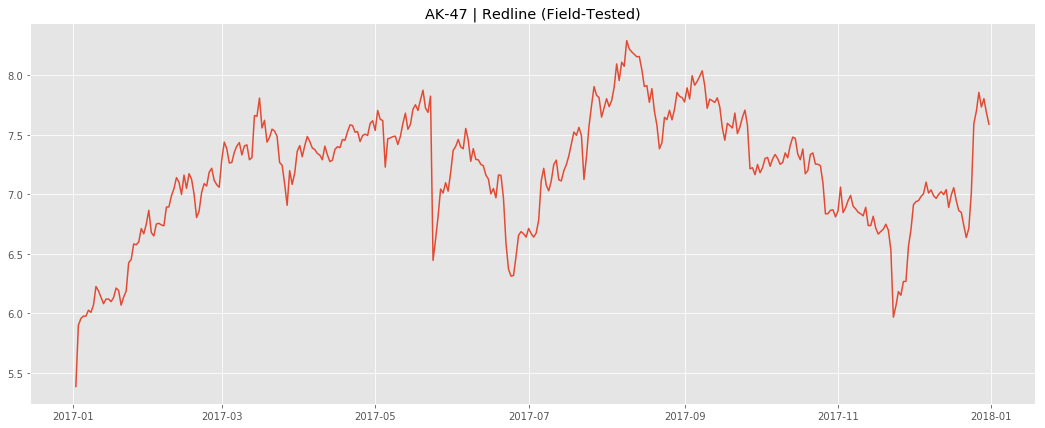

In [31]:
fig, ax = plt.subplots(figsize=(18, 7))
plot_raw(dfg, ax)

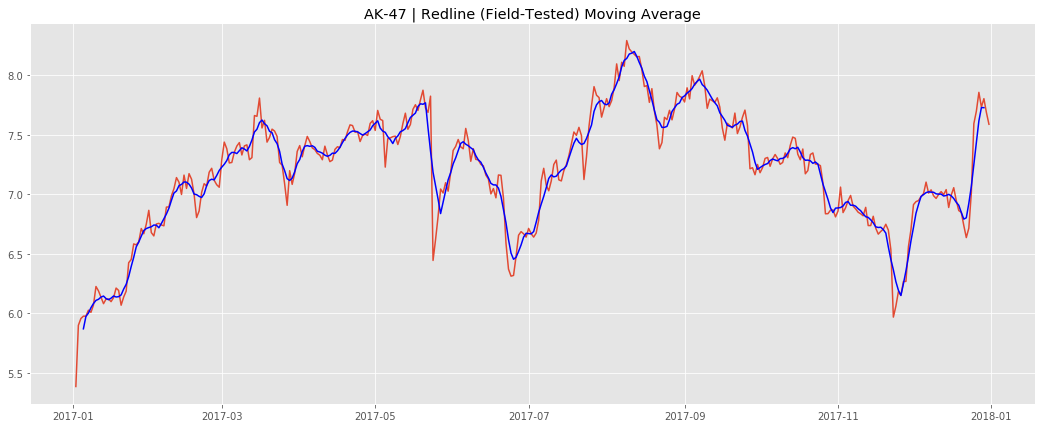

In [11]:
fig, ax = plt.subplots(figsize=(18, 7))
plot_moving_average(dfg, ax)

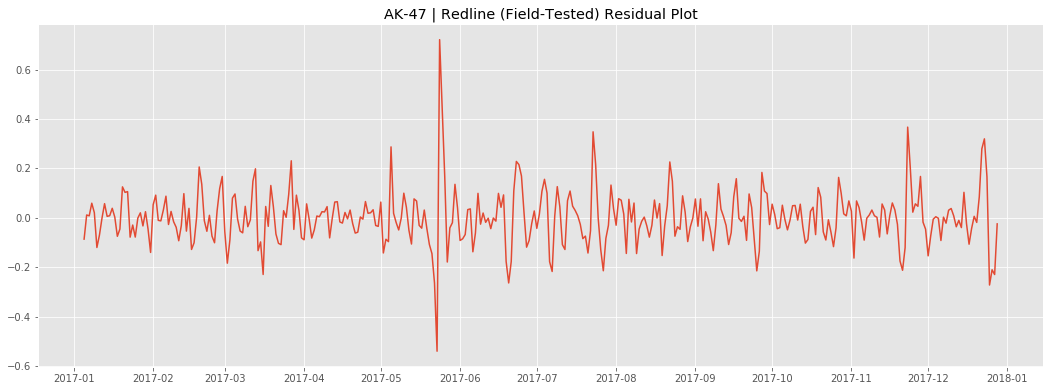

In [45]:
import matplotlib.dates as mdates
months = mdates.MonthLocator()
fig, ax = plt.subplots(figsize=(18, 7))
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plot_resid(dfg, ax)

In [18]:
dfkey = df[df['item_name'] == 'Mann Co. Supply Crate Key']
dfkey = dfkey[dfkey['date'] > tots('Jan 01 2014')]

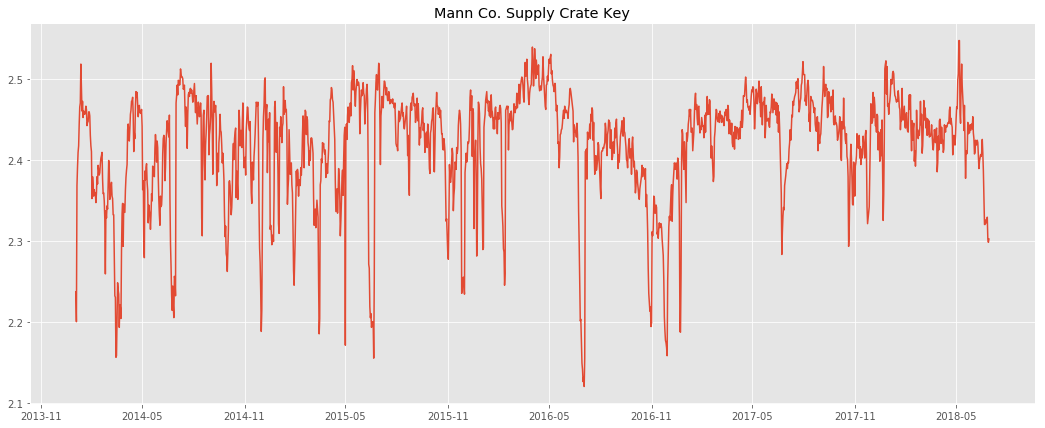

In [19]:
fig, ax = plt.subplots(figsize=(18, 7))
plot_raw(dfkey, ax)

# Nice formatting on the ticks and dates

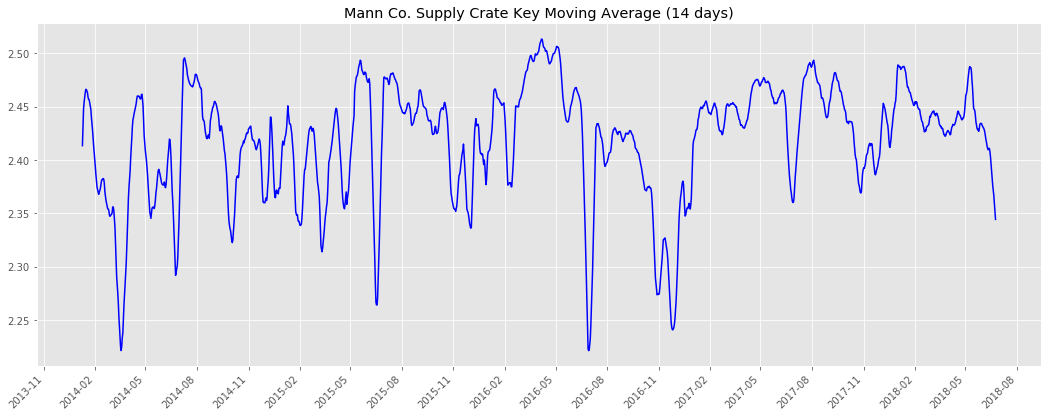

In [58]:
import matplotlib.dates as mdates
months = mdates.MonthLocator(interval=3)
fig, ax = plt.subplots(figsize=(18, 7))
fig.autofmt_xdate(rotation=45)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plot_moving_average(dfkey, ax, draw_raw=False, window=14)

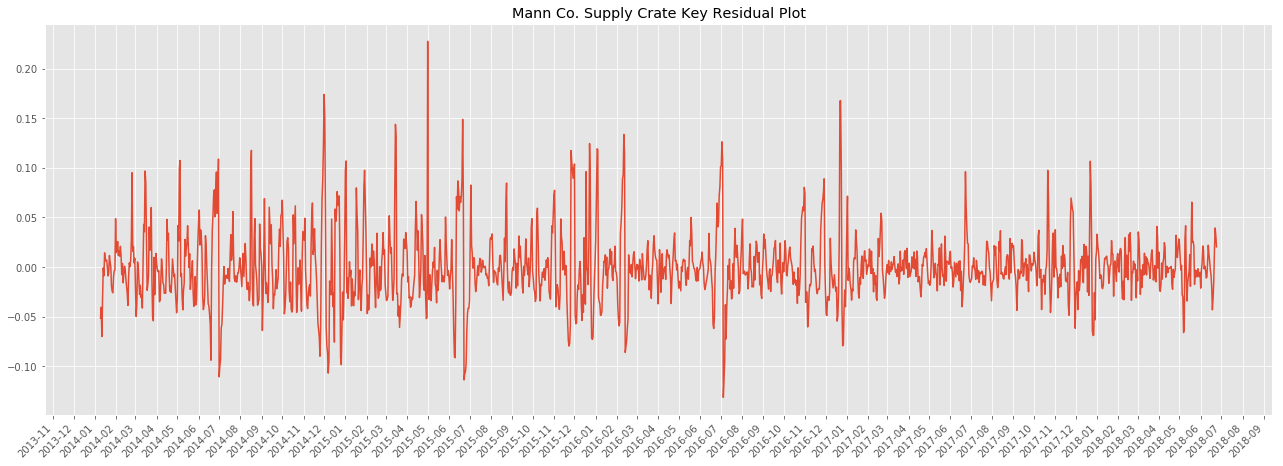

In [65]:
fig, ax = plt.subplots(figsize=(22, 8))
fig.autofmt_xdate(rotation=45)
plot_resid(dfkey, ax, window=14)

In [84]:
dfg2 = dfg.copy()
dfg2.date=[fromts(t) for t in dfg2.date]
def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(month).ix[:, :11]

In [85]:
dfg2.index=dfg2.date
dfg2.head()

,app,date,item_name,median_sell_price,quantity
date,,,,,
2017-01-02,730,2017-01-02,AK-47 | Redline (Field-Tested),5.386,3304
2017-01-03,730,2017-01-03,AK-47 | Redline (Field-Tested),5.900,2501
2017-01-04,730,2017-01-04,AK-47 | Redline (Field-Tested),5.957,2486
2017-01-05,730,2017-01-05,AK-47 | Redline (Field-Tested),5.977,2352
2017-01-06,730,2017-01-06,AK-47 | Redline (Field-Tested),5.977,2442


In [101]:
def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, series):
    seasons_average_trend = fit_seasonal_trend(series)
    ax.plot(series.index, series)
    ax.plot(series.index, seasons_average_trend)
    
def plot_decomposed_seasons(ax, series):
    seasons_average_trend = fit_seasonal_trend(series)
    ax.plot(series.index, seasons_average_trend - series.values)

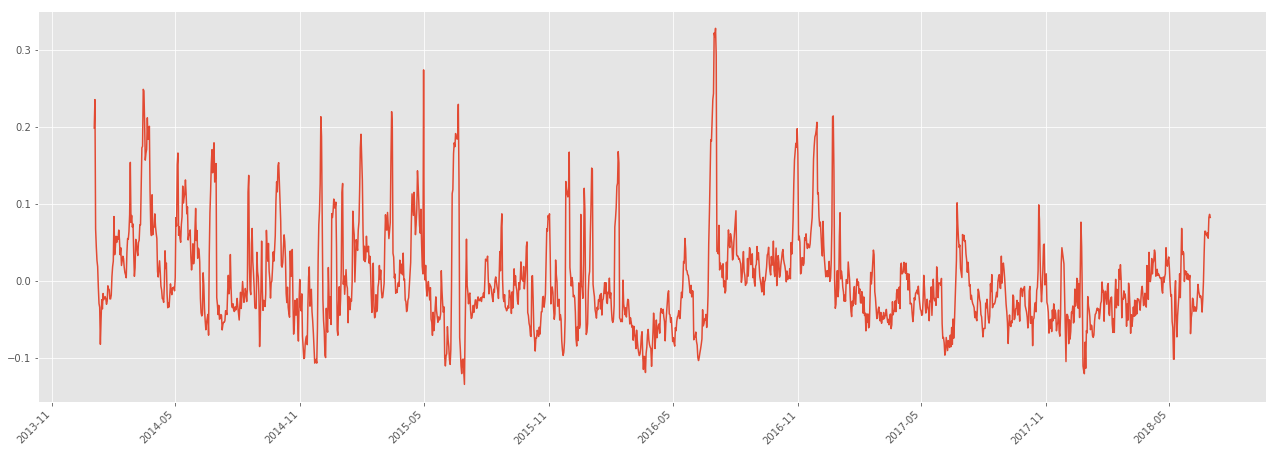

In [108]:
#dfg2.date=[datetime.datetime.timestamp(t) for t in dfg2.date]
fig, ax = plt.subplots(figsize=(22, 8))
fig.autofmt_xdate(rotation=45)
plot_decomposed_seasons(ax, dfkey.median_sell_price)

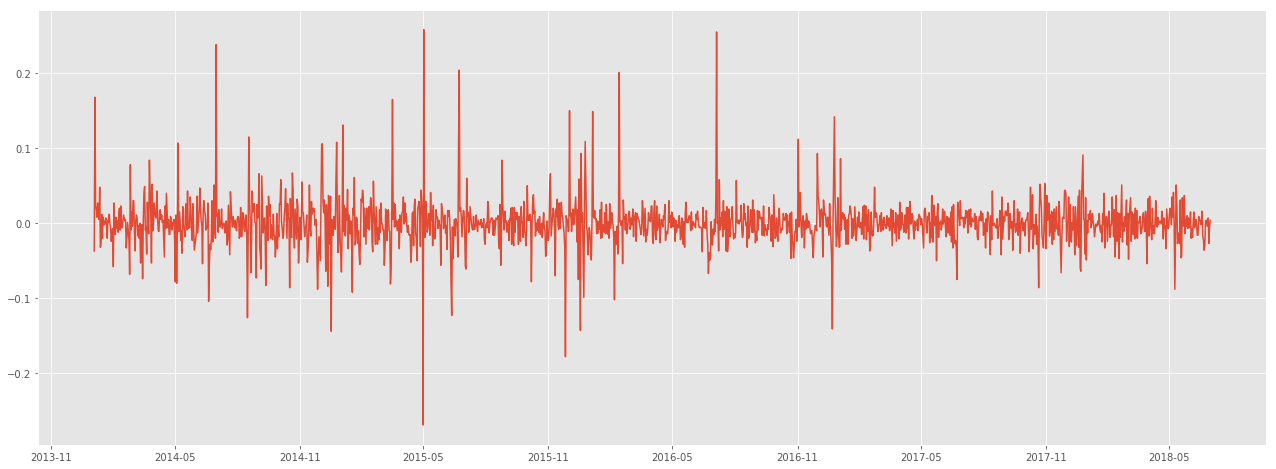

In [111]:
fig, ax = plt.subplots(figsize=(22,8))
ax.plot(dfkey.median_sell_price.diff())

In [115]:
dfkey.loc[pd.Timestamp('2015-04-28 00:00:00'):pd.Timestamp('2015-05-28 00:00:00')]

,app,date,item_name,median_sell_price,quantity
date,,,,,
2015-04-28,440,1.430197e+09,Mann Co. Supply Crate Key,2.400,6649
2015-04-29,440,1.430284e+09,Mann Co. Supply Crate Key,2.430,4699
2015-04-30,440,1.430370e+09,Mann Co. Supply Crate Key,2.440,5323
2015-05-01,440,1.430456e+09,Mann Co. Supply Crate Key,2.171,9122
2015-05-02,440,1.430543e+09,Mann Co. Supply Crate Key,2.429,7152
2015-05-03,440,1.430629e+09,Mann Co. Supply Crate Key,2.444,6605
2015-05-04,440,1.430716e+09,Mann Co. Supply Crate Key,2.425,5627
2015-05-05,440,1.430802e+09,Mann Co. Supply Crate Key,2.454,4323
2015-05-06,440,1.430888e+09,Mann Co. Supply Crate Key,2.465,4769


In [127]:
np.sort(dfkey.quantity.values)[-1:-10:-1]

array([44430, 42956, 42739, 42379, 41484, 39970, 38437, 38270, 35908])

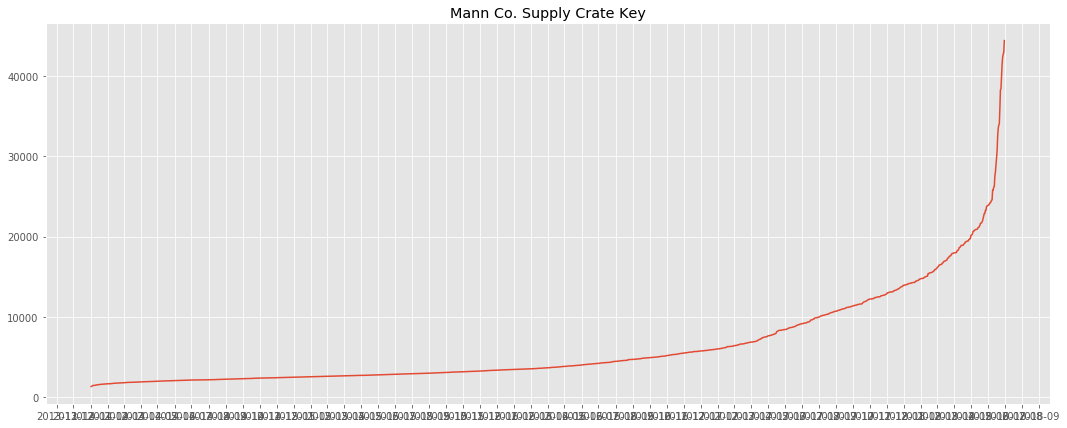

In [128]:
fig, ax = plt.subplots(figsize=(18, 7))
plot_raw(dfkey, ax, ycol='quantity')